In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

## Load Dataset

In [2]:
# re-load in train set and test set
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

id_train = train_df['PassengerId']
train_df.drop(labels=['PassengerId'], axis=1, inplace=True)

id_test = test_df['PassengerId']
test_df.drop(labels=['PassengerId'], axis=1, inplace=True)

## Data Preprocessing

In [3]:
# age imputation
def age_impute(train_df, test_df):
#     for df in [train_df, test_df]:
#         df['Has_age'] = df['Age'].apply(lambda x: 0 if x is np.nan else 1)
#     age_med = train_df['Age'].median()
#     for df in [train_df, test_df]:
#         index_NaN = list(df['Age'][df['Age'].isnull()].index)
#         for i in index_NaN:
#             age_pred = train_df["Age"][((train_df["Pclass"] == train_df.iloc[i]["Pclass"]) &
#                                         (train_df["Parch"] == train_df.iloc[i]["Parch"]) &
#                                         (train_df["SibSp"] == train_df.iloc[i]["SibSp"]))].median()
#             if np.isnan(age_pred):
#                 df['Age'].iloc[i] = age_med
#             else:
#                 df['Age'].iloc[i] = age_pred
    for df in [train_df, test_df]:
        df['Has_age'] = df['Age'].apply(lambda x: 0 if x is np.nan else 1)
        age_group = train_df.groupby(['Title', 'Pclass'])['Age']
        df['Age'] = age_group.transform(lambda x: x.fillna(x.mean()))
    
    return train_df, test_df

In [4]:
# cabin imputation
def cabin_info(train_df, test_df):
#     cabin_letter = {'A': 1, 'B': 2, 'C': 3, 'D':4, 'E': 5, 'F': 6, 'G': 7, 
#                     'T': 8, 'missing': 9}
    for df in [train_df, test_df]:
#         df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if x is np.nan else 1)
        
        df['Cabin_num1'] = df['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        df['Cabin_num1'].replace('an', np.nan, inplace = True)
        df['Cabin_num1'] = df['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.nan)
    
    train_df['Cabin_num'], bins = pd.qcut(train_df['Cabin_num1'], 3, retbins=True)
    test_df['Cabin_num'] = pd.cut(test_df['Cabin_num1'], bins=bins, include_lowest=True)
    train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix = 'Cabin_num')), axis = 1)

    for df in [train_df, test_df]:
#         df['Cabin_letter'] = df['Cabin'].apply(lambda x: 'missing' if x is np.nan 
#                                                    else str(x)[0])
#         df['Cabin_letter'] = df['Cabin_letter'].map(cabin_letter)
#         # convert cabin letter other than the dict into 0
#         df['Cabin_letter'] = df['Cabin_letter'].fillna(0)
#         df['Cabin_letter'] = df['Cabin_letter'].astype(int)
        df['Cabin_letter'] = df['Cabin'].apply(lambda x: str(x)[0])

    for df in [train_df, test_df]:
        del df['Cabin']
        del df['Cabin_num1']
        del df['Cabin_num']

    return train_df, test_df

In [5]:
# family size
def family_size(train_df, test_df):
    for df in [train_df, test_df]:
        df['Family_size'] = df['Parch'] + df['SibSp'] + 1
        df['Family_size'] = np.where((df['SibSp']+df['Parch'])==0 , 'Single',
                               np.where((df['SibSp']+df['Parch'])<=3,'Nuclear', 'Big'))
        
        del df['Parch']
        del df['SibSp']

    return train_df, test_df

In [6]:
# name
def passenger_name(train_df, test_df):
#     title_dict = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3}
    for df in [train_df, test_df]:
        # name length
        df['Name_length'] = df['Name'].apply(len)
        # title
        df['Title'] = df['Name'].str.split(', ', expand=True)[1]
        df['Title'] = df['Title'].str.split('. ', expand=True)[0]
#         df['Title'] = df['Title'].map(title_dict)
#         # convert other title into 4
#         df['Title'] = df['Title'].fillna(4)
#         df['Title'] = df['Title'].astype(int)
        
        del df['Name']
        
    return train_df, test_df

In [7]:
# ticket
def ticket_info(train_df, test_df):
    ticket_higher_chance = ['1', '2', '3', 'S', 'P', 'C', 'A']
    ticket_lower_chance = ['W', '4', '7', '6', 'L', '5', '8']
    for df in [train_df, test_df]:
        df['Ticket_length'] = df['Ticket'].apply(len)
        df['Ticket_letter'] = df['Ticket'].apply(lambda x: str(x)[0])
        df['Ticket_letter'] = np.where((df['Ticket_letter']).isin(ticket_higher_chance), df['Ticket_letter'],
                                   np.where((df['Ticket_letter']).isin(ticket_lower_chance), 'Low_ticket', 
                                            'Other_ticket'))
        
        del df['Ticket']
    
    return train_df, test_df

In [8]:
# embarked
def embark_impute(train_df, test_df):
    embark_median = train_df['Embarked'].mode()[0]
    for df in [train_df, test_df]:
        df['Embarked'] = df['Embarked'].fillna(embark_median)
        
    return train_df, test_df

In [9]:
# fare
def fare_impute(train_df, test_df):
    fare_median = train_df['Fare'].median()
    for df in [train_df, test_df]:
        df['Fare'] = df['Fare'].fillna(fare_median)
#         # reduce skewness
#         df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x>0 else 0)
    
    return train_df, test_df

In [10]:
# get dummy variables
def dummies(train_df, test_df, columns):
    for col in columns:
        train_df[col] = train_df[col].apply(lambda x: str(x))
        test_df[col] = test_df[col].apply(lambda x: str(x))
        good_cols = [col+'_'+i for i in train_df[col].unique() if i in test_df[col].unique()]
        train_df = pd.concat((train_df, pd.get_dummies(train_df[col], prefix = col)[good_cols]), axis = 1)
        test_df = pd.concat((test_df, pd.get_dummies(test_df[col], prefix = col)[good_cols]), axis = 1)
        del train_df[col]
        del test_df[col]
        
    return train_df, test_df

In [11]:
train_df, test_df = passenger_name(train_df, test_df)
train_df, test_df = age_impute(train_df, test_df)
train_df, test_df = cabin_info(train_df, test_df)
train_df, test_df = family_size(train_df, test_df)
train_df, test_df = ticket_info(train_df, test_df)
train_df, test_df = embark_impute(train_df, test_df)
train_df, test_df = fare_impute(train_df, test_df)
dummies_list = ['Pclass', 'Sex', 'Embarked', 'Ticket_letter', 
                'Cabin_letter', 'Title', 'Family_size']
train_df, test_df = dummies(train_df, test_df, dummies_list)

In [12]:
train_df.head()

Survived   Age     Fare  Name_length  Has_age  Cabin_num_(1.999, 28.667]  \
0         0  22.0   7.2500           23        1                          0   
1         1  38.0  71.2833           51        1                          0   
2         1  26.0   7.9250           22        1                          0   
3         1  35.0  53.1000           44        1                          0   
4         0  35.0   8.0500           24        1                          0   

   Cabin_num_(28.667, 65.667]  Cabin_num_(65.667, 148.0]  Ticket_length  \
0                           0                          0              9   
1                           0                          1              8   
2                           0                          0             16   
3                           0                          1              6   
4                           0                          0              6   

   Pclass_3       ...         Title_Mrs  Title_Miss  Title_Master  Title_Rev  \
0         1       ...                 0           0             0          0   
1         0       ...                 1           0             0          0   
2         1       ...                 0           1             0          0   
3         0       ...                 1           0             0          0   
4         1       ...                 0           0             0          0   

   Title_Dr  Title_Ms  Title_Col  Family_size_Nuclear  Family_size_Single  \
0         0         0          0                    1                   0   
1         0         0          0                    1                   0   
2         0         0          0                    0                   1   
3         0         0          0                    1                   0   
4         0         0          0                    0                   1   

   Family_size_Big  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 45 columns]

## Modeling

In [13]:
y_train = train_df['Survived']
X_train = train_df.drop(labels=['Survived'], axis=1)

In [14]:
kfold = StratifiedKFold(n_splits = 10)

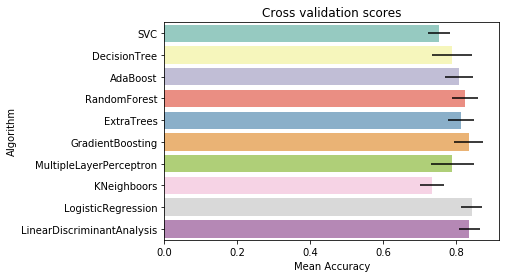

In [15]:
# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.1))
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(MLPClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring = "accuracy", cv=kfold))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means,"CrossValerrors": cv_std,
                       "Algorithm": ["SVC","DecisionTree","AdaBoost",
                       "RandomForest", "ExtraTrees", "GradientBoosting",
                       "MultipleLayerPerceptron", "KNeighboors",
                       "LogisticRegression", "LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3",
                orient="h", **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [16]:
cv_res

CrossValMeans  CrossValerrors                   Algorithm
0       0.752067        0.030638                         SVC
1       0.788995        0.054457                DecisionTree
2       0.807011        0.038198                    AdaBoost
3       0.822604        0.035685                RandomForest
4       0.812693        0.035138                  ExtraTrees
5       0.833979        0.040035            GradientBoosting
6       0.789221        0.059578     MultipleLayerPerceptron
7       0.732902        0.032625                 KNeighboors
8       0.841719        0.027790          LogisticRegression
9       0.836126        0.029402  LinearDiscriminantAnalysis

LogisticRegression has the highest accuracy

choose LogisticRegression, GradientBoosting, LinearDiscriminantAnalysis, RandomForest for the ensemble modeling

### Hyperparameter tunning


#### Logistic Regression

In [17]:
# logistic regression
LRC = LogisticRegression()
lr_param_grid = {"penalty": ["l1", "l2"],
                 "C": [1, 0.5, 0.1, 0.05, 0.01]}

gsLRC = GridSearchCV(LRC, param_grid = lr_param_grid, cv = kfold, 
                     scoring = "accuracy", verbose = 1)

gsLRC.fit(X_train, y_train)

LRC_best = gsLRC.best_estimator_

gsLRC.best_score_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


0.8417508417508418

#### Gradient Boosting

In [18]:
# gradient boosting
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100, 200, 300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100, 150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, 
                     scoring = "accuracy", verbose = 1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.3min finished


0.8417508417508418

#### Linear Discrimination Analysis

In [19]:
# Linear Discrimination Analysis
LDAC = LinearDiscriminantAnalysis()
lda_param_grid = {"solver": ["lsqr", "eigen"],
                  "shrinkage": ["auto"],
                  }

gsLDAC = GridSearchCV(LDAC, param_grid = lda_param_grid, cv = kfold, 
                     scoring = "accuracy", verbose = 1)

gsLDAC.fit(X_train, y_train)

LDAC_best = gsLDAC.best_estimator_

gsLDAC.best_score_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


0.8361391694725028

#### RandomForest

In [20]:
# random forest
RFC = RandomForestClassifier()
rf_param_grid = {"min_samples_split": [2, 4, 10, 12, 16],
                  "min_samples_leaf": [1, 5, 10],
                  "n_estimators" :[50, 100, 400, 700, 1000],
                  "criterion": ["gini", "entropy"]}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, 
                     scoring = "accuracy", verbose = 1)

gsRFC.fit(X_train, y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 13.6min finished


0.8439955106621774

### Learning Curve


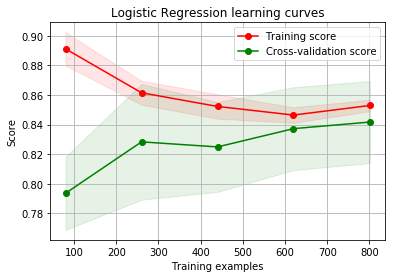

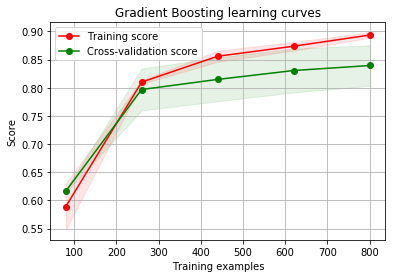

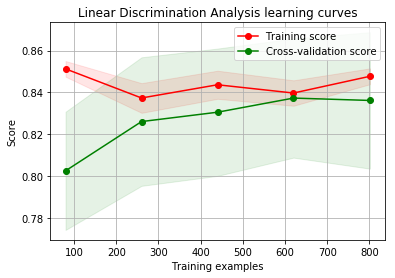

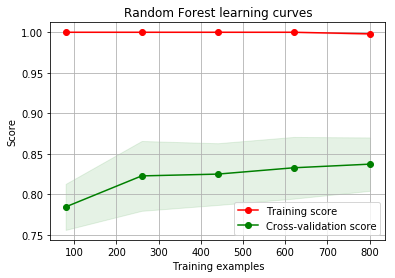

In [22]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, 
                        train_sizes = np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")

    plt.legend(loc = "best")
    return plt

g = plot_learning_curve(gsLRC.best_estimator_,"Logistic Regression learning curves",
                        X_train, y_train, cv = kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"Gradient Boosting learning curves",
                        X_train, y_train, cv = kfold)
g = plot_learning_curve(gsLDAC.best_estimator_,"Linear Discrimination Analysis learning curves",
                        X_train, y_train, cv = kfold)
g = plot_learning_curve(gsRFC.best_estimator_,"Random Forest learning curves",
                        X_train, y_train, cv = kfold)

Random Forest is overfitting, should perform better if more training examples

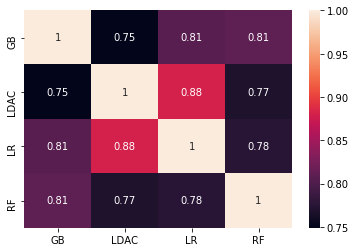

In [23]:
test_Survived_GBC = pd.Series(GBC_best.predict(test_df), name="GB")
test_Survived_LDAC = pd.Series(LDAC_best.predict(test_df), name="LDAC")
test_Survived_LRC = pd.Series(LRC_best.predict(test_df), name="LR")
test_Survived_RFC = pd.Series(RFC_best.predict(test_df), name="RF")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_GBC, test_Survived_LDAC,
                              test_Survived_LRC, test_Survived_RFC 
                              ],
                              axis = 1)


g = sns.heatmap(ensemble_results.corr(), annot=True)

prediction is quite similar => should not be used to ensemble model<br>
but we can take a shot

In [24]:
votingC = VotingClassifier(estimators = [('RF', RFC_best),
                                         ('GB', GBC_best), 
                                         ('LR', LRC_best),
                                         ('LD', LDAC_best)], 
                           voting = 'soft')

votingC = votingC.fit(X_train, y_train)

## Prediction


### Prediction by Ensemble Model

In [25]:
test_Survived = pd.Series(votingC.predict(test_df), name = "Survived")

results = pd.concat([id_test.reset_index(drop = True),
                     test_Survived], axis = 1)

results.to_csv("ensemble_python_voting.csv", index = False)

### Prediction by Gradient Boosting (Model with highest Val_Accuracy)

In [27]:
result = pd.Series(GBC_best.predict(test_df), name = "Survived")

result = pd.concat([id_test.reset_index(drop = True),
                     result], axis = 1)

result.to_csv("result.csv", index = False)

## Conclusion
The result of ensemble model scores around 0.8 while Gradient Boosing scores around 0.78. The ensemble model beats all other single model even the voting estimators have a high correlation.